# Capstone Three: 3. Modeling - Supervised<a id='3'></a>

## 3.1 Contents<a id='3.1'></a>
* [3. Modeling - Supervised](#3)
  * [3.1 Contents](#3.1)
  * [3.2 Imports](#3.2)
  * [3.3 Load Data and Prepocessing](#3.3)
  * [3.4 Modeling W/O Resampling](#3.4)
    * [3.4.1 Logistic Regression](#3.4.1)
    * [3.4.2 XGBoost](#3.4.2)
    * [3.4.3 LightGBM](#3.4.3)
  * [3.5 Modeling W/ Resampling](#3.5)
    * [3.5.1 Resampling](#3.5.1)
    * [3.5.2 Logistic Regression](#3.5.2)
    * [3.5.3 XGBoost](#3.5.3)
    * [3.5.4 LightGBM](#3.5.4)
  * [3.6 Summary](#3.6)

## 3.2 Imports<a id='3.2'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 3.3 Load Data and Preprocessing<a id='3.3'></a>

In [2]:
data = pd.read_csv("data.csv")

In [3]:
X = data.drop(['Time', 'Class'], axis=1)   # Predictors
y = data['Class']                          # Predictand

# Train-test Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8,
                                                    random_state = 42, stratify=y)

# Reset index
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Combine train and test data into dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Save train and test data to csv files
train_df.to_csv('train.csv',index=False)
test_df.to_csv('test.csv',index=False)

In [4]:
# Standard Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 3.4 Modeling W/O Resampling<a id='3.4'></a>

### 3.4.1 Logistic Regression<a id='3.4.1'></a>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.85      0.58      0.69        95

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.84     56746
weighted avg       1.00      1.00      1.00     56746



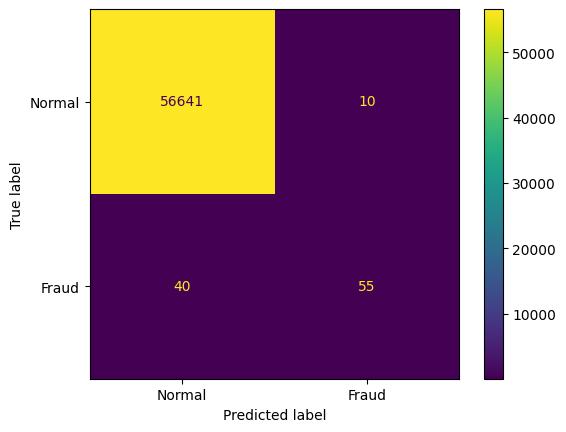

In [5]:
logisticRegr = LogisticRegression(solver = 'liblinear', max_iter = 500)
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
LR_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.4.2 XGBoost<a id='3.4.2'></a>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.76      0.85        95

    accuracy                           1.00     56746
   macro avg       0.99      0.88      0.93     56746
weighted avg       1.00      1.00      1.00     56746



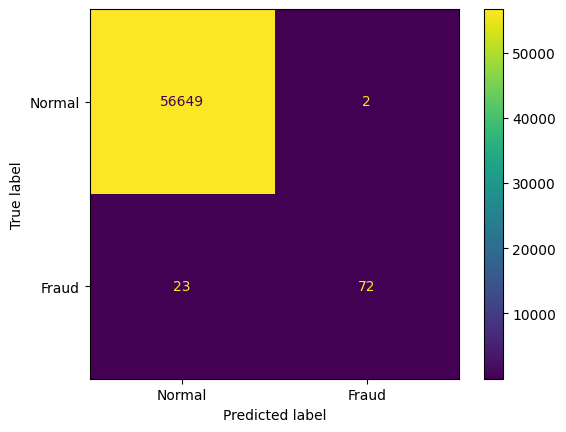

In [6]:
xbg = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=500)
xbg.fit(X_train, y_train)
y_pred = xbg.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
XGB_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.4.3 LightGBM<a id='3.4.3'></a>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.71      0.46      0.56        95

    accuracy                           1.00     56746
   macro avg       0.85      0.73      0.78     56746
weighted avg       1.00      1.00      1.00     56746



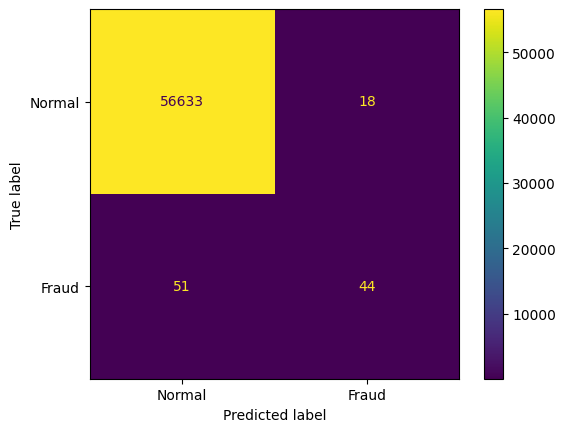

In [7]:
lgb = LGBMClassifier(learning_rate=0.1, max_depth=-3, n_estimators=500, num_leaves=31, verbose=-1)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
LGBM_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

XGboost gives the highest F1 score of 0.85. Logistic regression has an F1 score of 0.69. LightGBM is worst (F1 score=0.56), having True Positive (44) even less than False Positive (51). \
The above results are less sensitive to hyperparameters.

## 3.5 Modeling W/ Resampling<a id='3.5'></a>

### 3.5.1 Resampling<a id='3.5.1'></a>

In [8]:
rsp = RandomOverSampler(random_state=42)
X_train_rsp, y_train_rsp = rsp.fit_resample(X_train, y_train)

### 3.5.2 Logistic Regression<a id='3.5.2'></a>

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



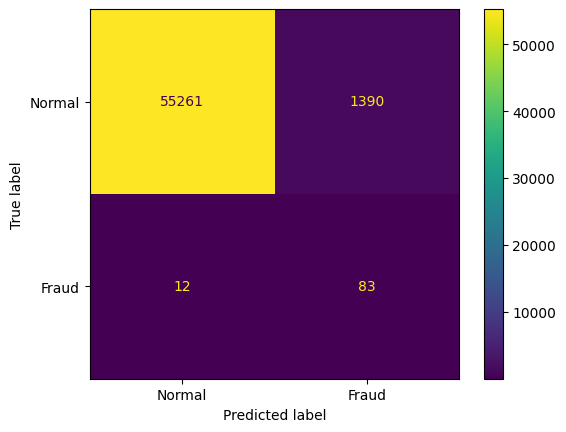

In [9]:
logisticRegr = LogisticRegression(solver = 'liblinear', max_iter = 500)
logisticRegr.fit(X_train_rsp, y_train_rsp)
y_pred = logisticRegr.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
LR_rsp_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.5.3 XGBoost<a id='3.5.3'></a>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.96      0.77      0.85        95

    accuracy                           1.00     56746
   macro avg       0.98      0.88      0.93     56746
weighted avg       1.00      1.00      1.00     56746



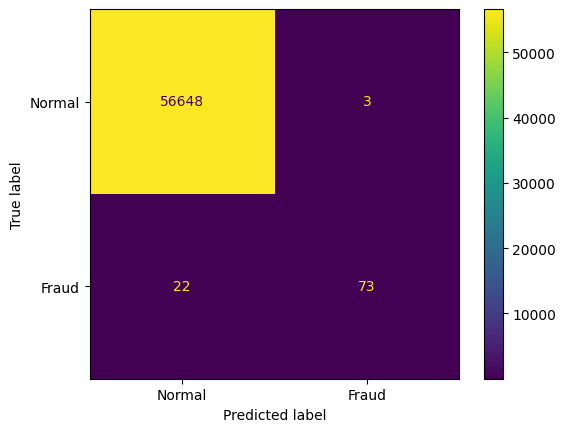

In [10]:
params=dict(learning_rate=0.2, max_depth=5, n_estimators=500)   # Identified using GridSearchCV
xbg_best = XGBClassifier(**params)
xbg_best.fit(X_train_rsp, y_train_rsp)
y_pred = xbg_best.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
XGB_rsp_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### 3.5.4 LightGBM<a id='3.5.4'></a>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.76      0.84        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746



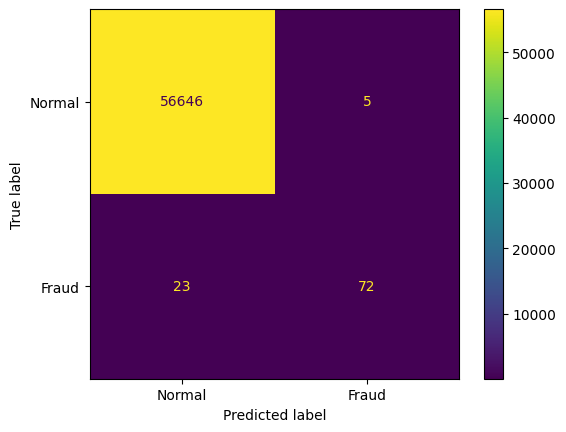

In [11]:
best_params=dict(learning_rate=0.1, max_depth=-3, n_estimators=500, num_leaves=31)
lgb_best = LGBMClassifier(**best_params,verbose=-1)
lgb_best.fit(X_train_rsp, y_train_rsp)
y_pred = lgb_best.predict(X_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)
LGBM_rsp_scores = [round(p[1], 2), round(r[1], 2), round(f[1], 2)]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Normal', 'Fraud'])
disp.plot()
plt.show()

### Combine metric scores from all models to a dataframe:

In [12]:
list_scores = [LR_scores, LR_rsp_scores, XGB_scores, XGB_rsp_scores, LGBM_scores, LGBM_rsp_scores]
df_scores = pd.DataFrame(list_scores)
df_scores.columns = ['Precision', 'Recall', 'F1 Score']

models = ['Logistic Regression', 'LR w/ Resampling', 'XGBoost', 'XGB w/ Resampling',
          'LightGBM', 'LGBM w/ Resampling']
df_scores.index = models
df_scores

,Precision,Recall,F1 Score
Logistic Regression,0.85,0.58,0.69
LR w/ Resampling,0.06,0.87,0.11
XGBoost,0.97,0.76,0.85
XGB w/ Resampling,0.96,0.77,0.85
LightGBM,0.71,0.46,0.56
LGBM w/ Resampling,0.94,0.76,0.84


In [13]:
# Save to csv files
df_scores.to_csv('scores_supervised.csv')

## 3.6 Summary<a id='3.6'></a>

#### **Without Resampling:**

**XGBoost** gives the highest F1 score of 0.85. \
**Logistic Regression** has a moderate F1 score of 0.69. \
**LightGBM** shows the lowest F1 score of 0.56, having True Positive (44) even less than False Positive (51).

#### **After Applying Resampling:**

**XGBoost** does NOT show much difference, still having similar high scores. \
**Logistic Regression** shows very low F1 score (0.11) and precision (0.06) but much higher recall (0.87).\
**LightGBM** shows higher F1 score, precision, and recall (similar to the results of XGBoost). 

For Resampling, I tried random undersampling and oversampling. Random undersampling gives much poorer prediction skills than random oversampling for all models as indicated by very low F1 scores and precision scores (less than 0.1).